In [243]:
!rm titanic_modified_dataset.csv
!cp /content/drive/MyDrive/data/titanic.zip .
!unzip titanic.zip

Archive:  titanic.zip
  inflating: titanic_modified_dataset.csv  


In [244]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.random.seed(1)
tf.random.set_seed(1)
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

# PREPARE DATA

In [245]:
data = np.genfromtxt('titanic_modified_dataset.csv', delimiter=',', skip_header=1)

# shuffle
idx = np.arange(data.shape[0])
np.random.shuffle(idx)
data = data[idx]

X = data[:,1:-1]
y = data[:,-1]

print(X.shape)
print(y.shape)

(891, 8)
(891,)


# CUSTOM DENSE LAYER

In [246]:
class MyDenseLayer(keras.layers.Layer):
    def __init__(self, num_units):
        super(MyDenseLayer, self).__init__()
        self.num_units = num_units

    def build(self, input_shape):
        self.kernel = self.add_weight('kernel', shape=[int(input_shape[-1]), self.num_units])
        self.bias = self.add_weight('bias', shape=[self.num_units])

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel) + self.bias

# CUSTOM ACTIVATION LAYER

In [247]:
class MyReluLayer(keras.layers.Layer):
    def __init__(self):
        super(MyReluLayer, self).__init__()

    def call(self, input):
        return tf.maximum(input, 0)

class MySoftmaxLayer(keras.layers.Layer):
    def __init__(self):
        super(MySoftmaxLayer, self).__init__()

    def call(self, input):
        denominator = tf.math.reduce_sum(tf.math.exp(input), axis=1)
        return tf.math.exp(input) / denominator[:, None]
    
    # def call(self, input):
    #     return keras.activations.softmax(input)

class MyLeakyReluLayer(keras.layers.Layer):
    def __init__(self):
        super(MyLeakyReluLayer, self).__init__()

    def call(self, input):
        return tf.maximum(input, 0.01*input)

# CUSTOM NORMALIZE LAYER

In [248]:
class MyNormalizeLayer(keras.layers.Layer):
    def __init__(self):
        super(MyNormalizeLayer, self).__init__()

    def call(self, input):
        mean_ = tf.math.reduce_mean(input, axis=0)
        std_ = tf.math.reduce_std(input, axis=0)
        return (input-mean_) / (std_+1e-6)

# BUILD MODEL WITH CUSTOM LAYERS
## Using 4 hidden layers and skip connection

In [249]:
input = MyNormalizeLayer()(keras.Input(shape=X.shape[1]))
hidden = MyNormalizeLayer()(MyReluLayer()(MyDenseLayer(num_units=32)(input)))
prev = hidden
prev = MyDenseLayer(num_units=8)(prev)

hidden = MyReluLayer()(MyDenseLayer(num_units=16)(hidden))
hidden = MyReluLayer()(MyDenseLayer(num_units=8)(hidden))

hidden = tf.math.add(prev, hidden)

hidden = MyLeakyReluLayer()(MyDenseLayer(num_units=8)(hidden))
output = MySoftmaxLayer()(MyDenseLayer(num_units=2)(hidden))

model = keras.Model(input, output)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0007), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [250]:
history = model.fit(X, y, batch_size=128, epochs=800, validation_split=0.2)

Epoch 1/800
6/6 [==============================] - 2s 58ms/step - loss: 0.9681 - accuracy: 0.4789 - val_loss: 0.9262 - val_accuracy: 0.5475
Epoch 2/800
6/6 [==============================] - 0s 8ms/step - loss: 0.8893 - accuracy: 0.5197 - val_loss: 0.8540 - val_accuracy: 0.5810
Epoch 3/800
6/6 [==============================] - 0s 9ms/step - loss: 0.8325 - accuracy: 0.5365 - val_loss: 0.7927 - val_accuracy: 0.5978
Epoch 4/800
6/6 [==============================] - 0s 9ms/step - loss: 0.7745 - accuracy: 0.5660 - val_loss: 0.7419 - val_accuracy: 0.6369
Epoch 5/800
6/6 [==============================] - 0s 9ms/step - loss: 0.7230 - accuracy: 0.5801 - val_loss: 0.7002 - val_accuracy: 0.6369
Epoch 6/800
6/6 [==============================] - 0s 9ms/step - loss: 0.6844 - accuracy: 0.5871 - val_loss: 0.6712 - val_accuracy: 0.6704
Epoch 7/800
6/6 [==============================] - 0s 9ms/step - loss: 0.6678 - accuracy: 0.6264 - val_loss: 0.6502 - val_accuracy: 0.6927
Epoch 8/800
6/6 [=========

In [251]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.968132,0.478933,0.926248,0.547486
1,0.889335,0.519663,0.853958,0.581006
2,0.832465,0.536517,0.792652,0.597765
3,0.774493,0.566011,0.741899,0.636872
4,0.723022,0.580056,0.700196,0.636872
...,...,...,...,...
795,0.315313,0.872191,0.498392,0.871508
796,0.320049,0.863764,0.504951,0.871508
797,0.305886,0.876405,0.508132,0.871508
798,0.310957,0.877809,0.507105,0.871508


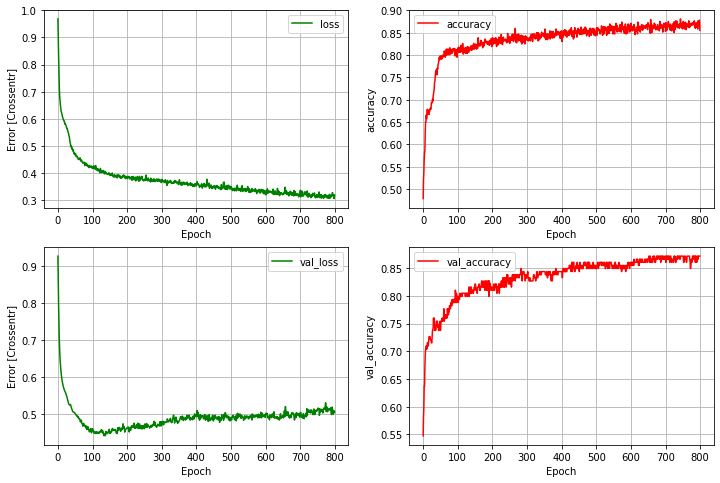

In [252]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [Crossentr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [Crossentr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(history.history['val_accuracy'], label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)

plt.show()